# Linden County Outage Creation
This notebook is used to create a feature class containing the contact information for parcel owners in an area impacted by a power outage event. It also generates an area of impact polygon to aid in identifying the full scale of the impact of the outage event.

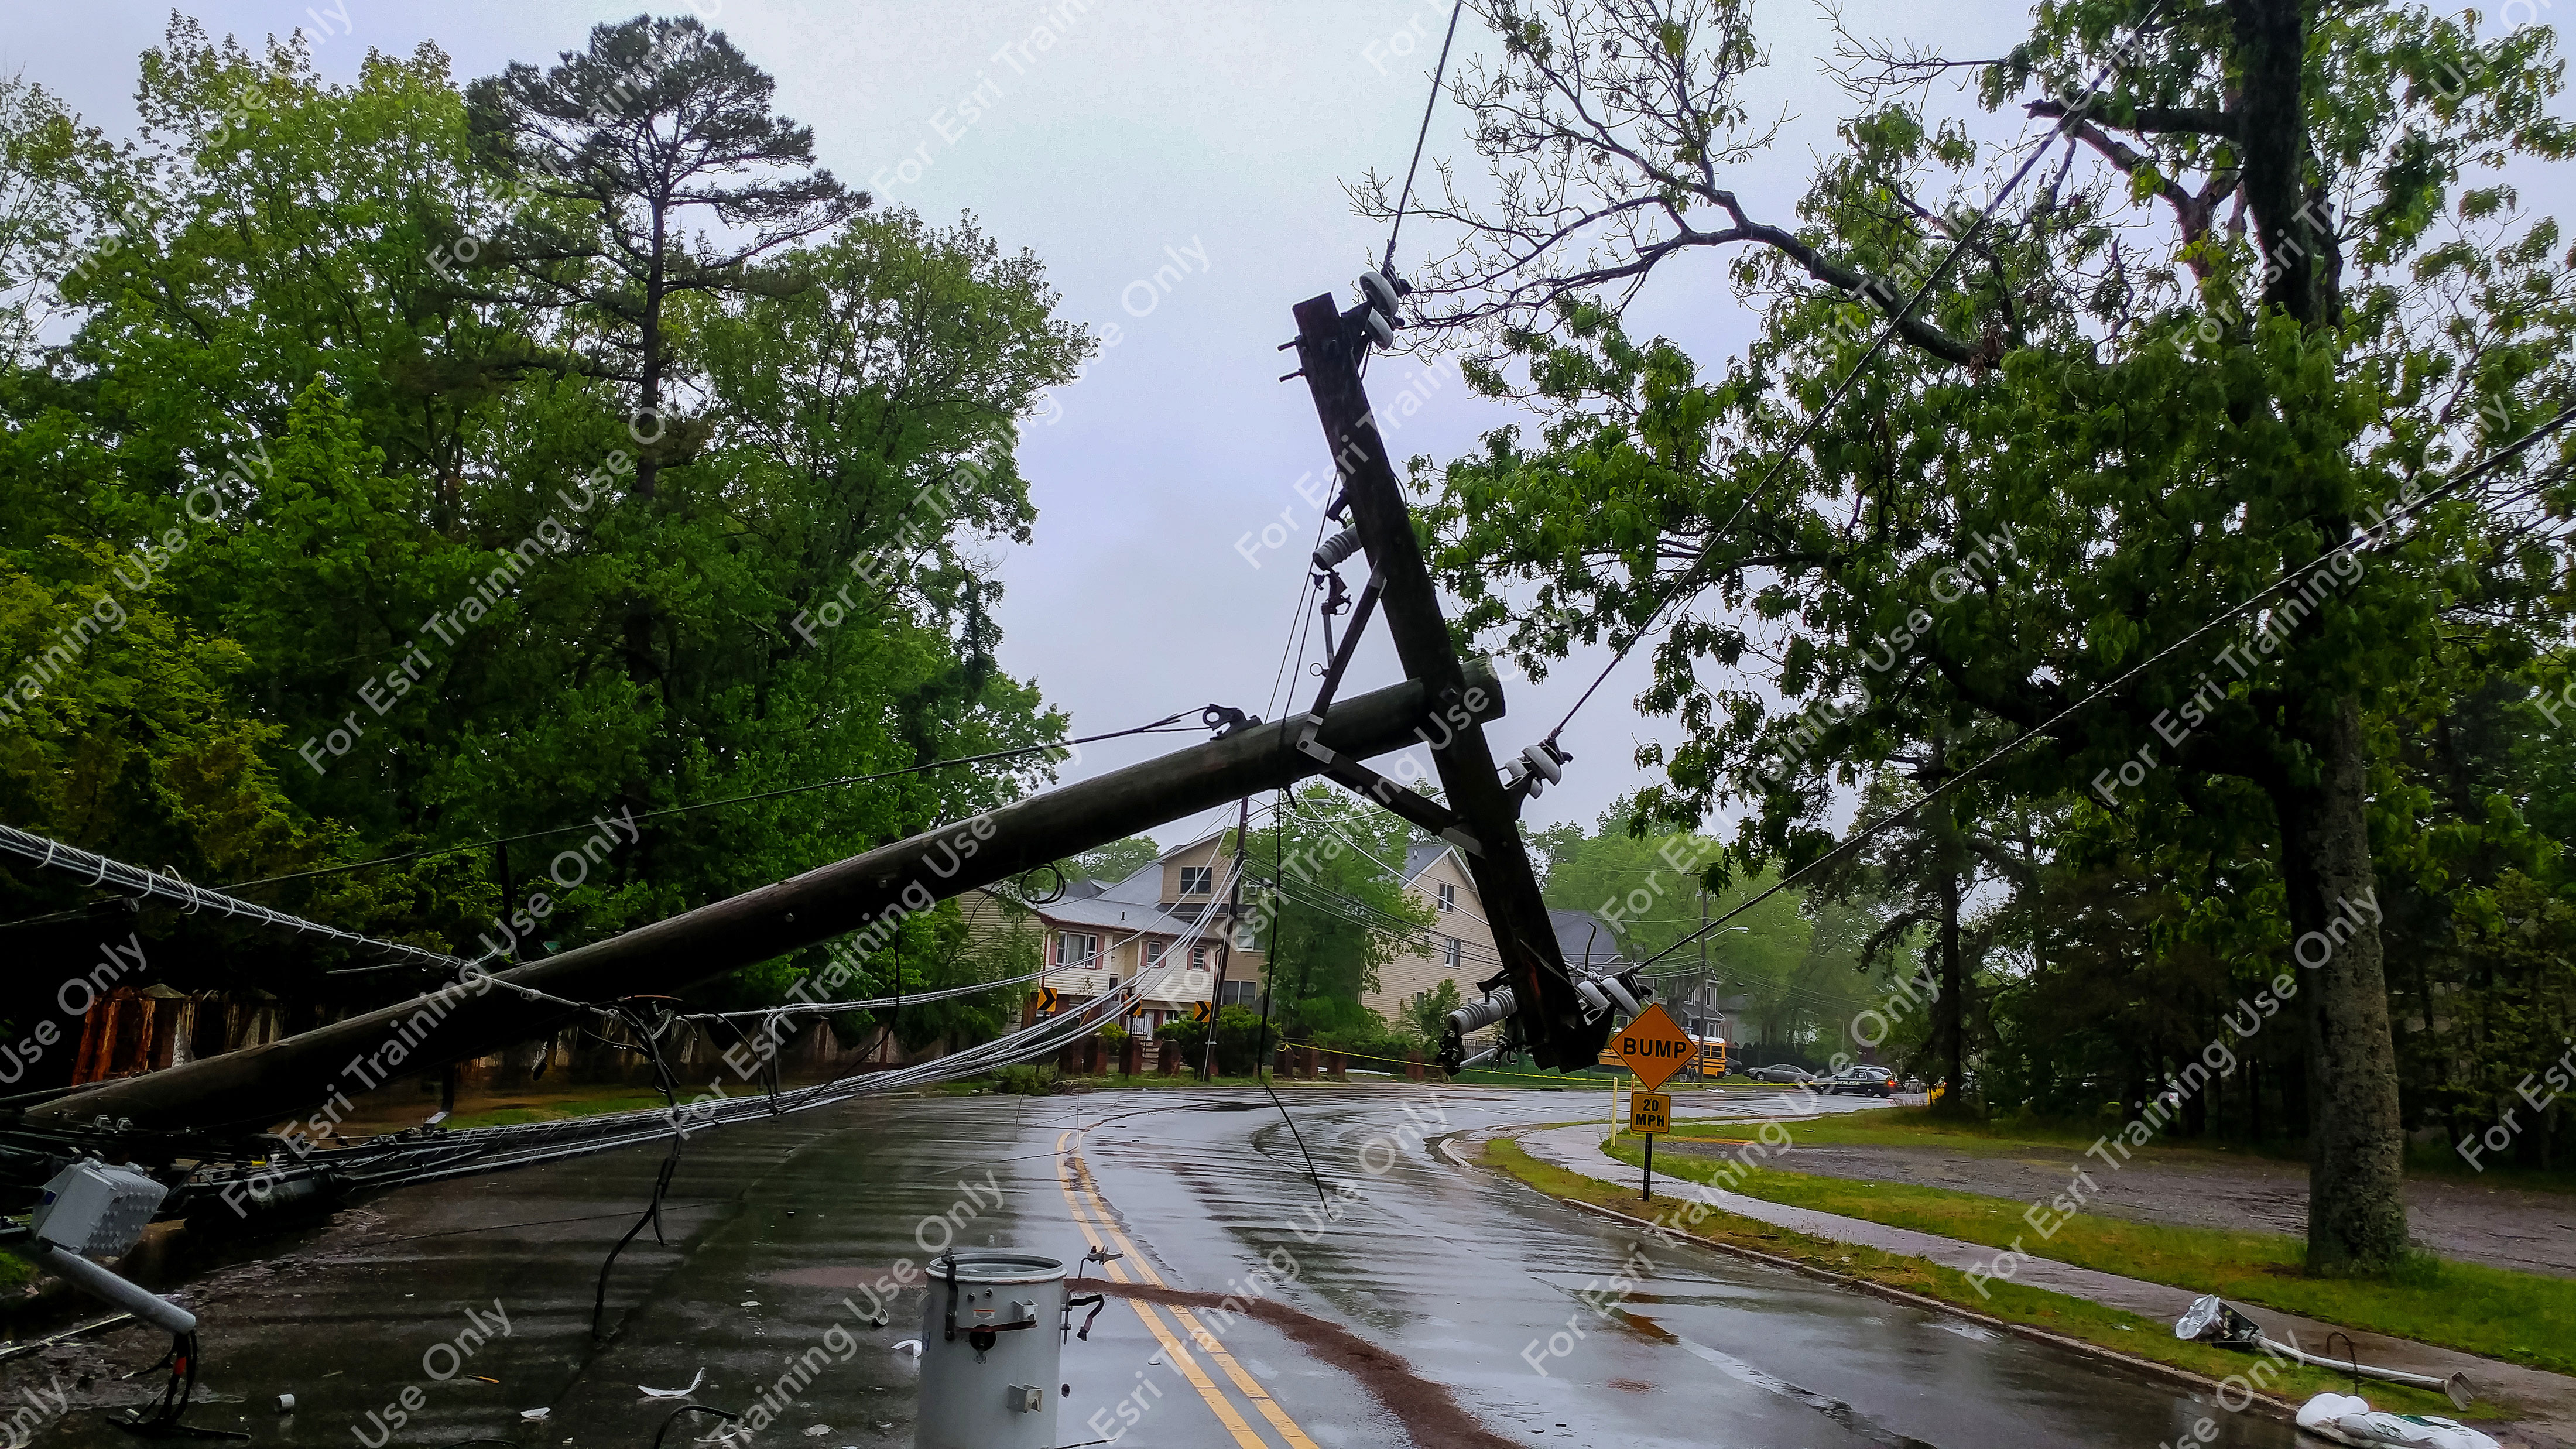

### Import modules and set environments
First, the notebook imports the CSV and ArcPy modules. Then it sets environment settings which enables overwriting existing files and ensures that the analysis and resulting files occurs in the NAD 1983 (CORS96) StatePlane North Carolina FIPS 3200 (US Feet) coordinate system. 

In [ ]:
import csv
import arcpy
arcpy.env.overwriteOutput = True
arcpy.env.outputCoordinateSystem = 103501
print("Modules imported")

### Set input variables
The script requires 2 input files:
- **outage_csv** - a CSV containing the X and Y coordinates for each outage. Coordinates should be in the same coordinate system as the analysis.
- **parcels** - a point feature class containing the parcel point features containing the contact information for each parcel owner. 

The script creates the following outputs:
- **outage_area** - the file to the output polygon feature class used to store the area of impact polygon
- **contact_fc** - the name to the output point feature class used to store the contact information of the impacted parcels' owners
- **gdb** - the file path to the geodatabase where the contact_fc feature class will be written

In [ ]:
outage_csv = r"C:\EsriTraining\PYTS\North_Carolina\OutageXY.csv"
outage_area= r"C:\EsriTraining\PYTS\North_Carolina\CountyData.gdb\CurrentAffectedAreas"
parcels = r"C:\EsriTraining\PYTS\North_Carolina\CountyData.gdb\ParcelPts"
contact_fc = "AffectedParcels"
gdb = r"C:\EsriTraining\PYTS\North_Carolina\CountyData.gdb"
print("Variables set")

### Read outage CSV into the script
Use the CSV module from base Python, to read the CSV data into the script. You will open the file, create a reader object on the CSV, and iterate through the reader, and add each coordinate pair to a Python list for future use in the module. 
To learn more about the CSV Module read the CSV module's [Python documentation](https://docs.python.org/3/library/csv.html)

In [ ]:
outage_coords = []
csv_file = open(outage_csv)
csv_reader = csv.reader(csv_file)
next(csv_reader)
for row in csv_reader:
    outage_coords.append(row)
print("Coordinates read from CSV")

### Create a geometry object from outage coordinates
Use the list of X,Y coordinates from the CSV file to create an ArcPy Array of Point objects. Then use the array to generate [a multipoint geometry object](https://pro.arcgis.com/en/pro-app/latest/arcpy/classes/multipoint.htm). 

In [ ]:
pnt_list = []
for coord in outage_coords:
    pnt = arcpy.Point(coord[0], coord[1])
    pnt_list.append(pnt)
pnt_ary = arcpy.Array(pnt_list)
outage_multipoint = arcpy.Multipoint(pnt_ary)
print("Multipoint geometry object created")

### Create the outage are using ConvexHull method
Use the Convex Hull geometry object method to return the area of impact polygon for outages. Then save the outage area created from the Convex Hull to a new, Polygon feature class.

In [ ]:
convex_hull = outage_multipoint.convexHull()
arcpy.CopyFeatures_management(convex_hull, outage_area)
print("Convex hull geometry object created and saved to feature class")

### Create and format a new feature class to store the contact list
You will need a record of impacted parcels for use in maps and to contact impacted Parcel owners. First, the script creates a new Point feature class in the output geodatabase. Second, it adds fields to store the owner name and phone numbers of each affected parcel. 

In [ ]:
arcpy.CreateFeatureclass_management(gdb, contact_fc, "POINT")
arcpy.AddFields_management(f"{gdb}\\{contact_fc}", [["Owner_Name", "TEXT"], ["Phone_Number", "TEXT"]])
print("Affected parcels feature class created")

### Create the affected parcel list
Finally, the script will use the SearchCursor and InsertCursor to go through the impacted parcel points and write the Owner information and location to the new feature class.

In [ ]:
with arcpy.da.SearchCursor(parcels, ["SHAPE@XY", "Owner_Name", "Phone_Number"]) as parcel_cursor:
    for parcel in parcel_cursor:
        pts = arcpy.Point((parcel[0])[0], (parcel[0])[1])
        parcel_geoms = arcpy.PointGeometry(pts)
        if parcel_geoms.within(convex_hull):
            cursor = arcpy.da.InsertCursor(f"{gdb}\\{contact_fc}", 
                                           ["SHAPE@XY", "Owner_Name", "Phone_Number"])
            cursor.insertRow([((parcel[0])[0], (parcel[0])[1]), parcel[1], parcel[2]])
            del cursor
        else:
            continue

del parcel_cursor
print("Affected parcel feature class populated \nScript completed")